# Scraping from Numbeo.com

In [372]:
# le clissque importé
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup
import geopandas
import geoplot
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [373]:
# list of urls
rent = 'https://www.numbeo.com/cost-of-living/prices_by_country.jsp?displayCurrency=EUR&itemId=28'
tomatoes = 'https://www.numbeo.com/cost-of-living/prices_by_country.jsp?displayCurrency=EUR&itemId=116'
nike = 'https://www.numbeo.com/cost-of-living/prices_by_country.jsp?displayCurrency=USD&itemId=64'
beef = 'https://www.numbeo.com/cost-of-living/prices_by_country.jsp?displayCurrency=USD&itemId=121'
wine = 'https://www.numbeo.com/cost-of-living/prices_by_country.jsp?displayCurrency=USD&itemId=14'
onions = 'https://www.numbeo.com/cost-of-living/prices_by_country.jsp?displayCurrency=USD&itemId=119'
cost_of_living = 'https://www.numbeo.com/cost-of-living/rankings_by_country.jsp?title=2020&displayColumn=0'

lasagna = onions + beef + tomatoes

In [374]:
# cost of living tables
groceries = 'https://www.numbeo.com/cost-of-living/rankings_by_country.jsp?title=2020&displayColumn=3'
rent = 'https://www.numbeo.com/cost-of-living/rankings_by_country.jsp?title=2020&displayColumn=1'
restaurants = 'https://www.numbeo.com/cost-of-living/rankings_by_country.jsp?title=2020&displayColumn=4'
gasoline = 'https://www.numbeo.com/cost-of-living/prices_by_country.jsp?displayCurrency=USD&itemId=24'
public_transportation = 'https://www.numbeo.com/cost-of-living/prices_by_country.jsp?displayCurrency=USD&itemId=20'

# quality of life tables
quality_of_life_total = 'https://www.numbeo.com/quality-of-life/rankings_by_country.jsp?title=2020&displayColumn=0'
climate = 'https://www.numbeo.com/quality-of-life/rankings_by_country.jsp?title=2020&displayColumn=8'
health_care = 'https://www.numbeo.com/health-care/rankings_by_country.jsp?title=2020&displayColumn=0'
crime = 'https://www.numbeo.com/crime/rankings_by_country.jsp?title=2020&displayColumn=0'
pollution = 'https://www.numbeo.com/pollution/rankings_by_country.jsp?title=2020&displayColumn=0'

In [375]:
# now it works, let's define a function:

def country_value(s):
    head = s.rstrip('0123456789.')
    tail = s[len(head):]
    return head, float(tail)


def scrape_numbeo(url, ascending= True):
    
    # functions gets url from table by country from numbeo.com
    # returns dataframe with country and value
    # value column is extracted from title of html
    
    # ask request from url
    response = requests.get(url)
    
    # cook the soup
    soup = BeautifulSoup(response.content, "html.parser")
    
    # get title to later name the column
    title_col = soup.title.text
    
    # find the table in the soup
    table = soup.find('table', id="t2")
    
    # get all rows
    rows = table.findAll('tr')
    
    # clean text in rows
    rows_text = [tag.text.replace('\n', '') for tag in rows][1:]
    
    # get values in a list of tuples
    values = [country_value(x) for x in rows_text]
    
    # create dataframe
    df = pd.DataFrame(values, columns= ['country', title_col])
    
    # change some country names for merging purposes
    df.loc[df['country'] == 'Palestinian Territory', 'country'] = 'Palestine'
    df.loc[df['country'] == 'Bosnia And Herzegovina', 'country'] = 'Bosnia and Herzegovina'
    df.loc[df['country'] == 'Kosovo (Disputed Territory)', 'country'] = 'Kosovo'
       
    return df.sort_values(by=df.columns[-1], ascending=ascending).reset_index(drop=True)

In [479]:
# let's define the plotting function

def world_map(df, colormap, cb_label):
    
    # receives a dataframe with data by country and makes a heat-world map based on the data
    
    # get geographical shape data
    world = geopandas.read_file('C:/Users/Zaca/Documents/Datasets/bra_adm1/BRA_adm1.shp')[['NAME_EN','geometry']]
    
    # change country names for merging purposes
    world.loc[world['NAME_EN'] == 'United States of America', 'NAME_EN'] = 'United States Of America'
    world.loc[world['NAME_EN'] == "People's Republic of China", 'NAME_EN'] = "People'S Republic Of China"
    world.loc[world['NAME_EN'] == "Republic of Macedonia", 'NAME_EN'] = 'Macedonia'
    
    # merge both datasets on country names
    data_merge = world.merge(df, left_on= 'NAME_EN', right_on='country')
    
    # plot the base map with black lines
    base = world[world.NAME_EN != "Antarctica"].plot(figsize=(15, 12), color='white', edgecolor='black', lw= 0.25, alpha=0.5)
    
    divider = make_axes_locatable(base)
    cax = divider.append_axes("right", size="2%", pad=0.1)
       
    # make the heatmap on top of base map
    #data_merge.plot(ax=base, column= df.columns[-1], legend= True, cmap=colormap, cax= cax, legend_kwds= {'label': cb_label})
    
    if cb_label == 'Intersection':
        data_merge.plot(ax=base, color= 'purple')
    else:
        data_merge.plot(ax=base, column= df.columns[-1], legend= True, cmap=colormap, cax= cax, legend_kwds= {'label': cb_label})
        
    
    base.axis('off')
    
    plt.savefig(cb_label + '.png', dpi=600)

In [377]:
cost_of_living_total = scrape_numbeo(cost_of_living, ascending=True)
cost_of_living_total

,country,Cost of Living Index by Country 2020
0,Pakistan,21.98
1,Afghanistan,24.24
2,India,24.58
3,Syria,25.31
4,Uzbekistan,26.01
...,...,...
127,Denmark,83.00
128,Japan,83.35
129,Iceland,100.48
130,Norway,101.43


In [378]:
# get the ranks for each country quality of life

health_care_df = scrape_numbeo(health_care, ascending= False)
health_care_df['rank_health'] = health_care_df.index

climate_df = scrape_numbeo(climate, ascending= False)
climate_df['rank_climate'] = climate_df.index

crime_df = scrape_numbeo(crime, ascending= True)
crime_df['rank_crime'] = crime_df.index

pollution_df = scrape_numbeo(pollution, ascending= True)
pollution_df['rank_pollution'] = pollution_df.index

total_quality_df = scrape_numbeo(quality_of_life_total, ascending= False)
total_quality_df['rank_total'] = total_quality_df.index

In [379]:
country_merge = crime_df[['country', 'rank_crime']].merge(health_care_df[['rank_health', 'country']], on='country', how='outer').merge(climate_df[['rank_climate', 'country']], on='country', how='outer').merge(pollution_df[['rank_pollution', 'country']], on='country', how='outer')

In [380]:
#country_merge['mean_rank'] = country_merge.mean(axis=1)

In [381]:
# get the ranks for each country cost of living
# cost of living links

groceries = 'https://www.numbeo.com/cost-of-living/rankings_by_country.jsp?title=2020&displayColumn=3'
rent = 'https://www.numbeo.com/cost-of-living/rankings_by_country.jsp?title=2020&displayColumn=1'
restaurants = 'https://www.numbeo.com/cost-of-living/rankings_by_country.jsp?title=2020&displayColumn=4'
gasoline = 'https://www.numbeo.com/cost-of-living/prices_by_country.jsp?displayCurrency=USD&itemId=24'
public_transportation = 'https://www.numbeo.com/cost-of-living/prices_by_country.jsp?displayCurrency=USD&itemId=20'
utilities = 'https://www.numbeo.com/cost-of-living/prices_by_country.jsp?displayCurrency=USD&itemId=30'

In [382]:
groceries_df = scrape_numbeo(groceries, ascending= True)
groceries_df['rank_groceries'] = groceries_df.index

rent_df = scrape_numbeo(rent, ascending= True)
rent_df['rank_rent'] = rent_df.index

restaurants_df = scrape_numbeo(restaurants, ascending= True)
restaurants_df['rank_restaurants'] = restaurants_df.index

gasoline_df = scrape_numbeo(gasoline, ascending= True)
gasoline_df['rank_gasoline'] = gasoline_df.index

public_transportation_df = scrape_numbeo(public_transportation, ascending= True)
public_transportation_df['rank_public_transportation'] = public_transportation_df.index

utilities_df = scrape_numbeo(utilities, ascending= True)
utilities_df['rank_utilities'] = utilities_df.index

In [383]:
life = country_merge.merge(groceries_df[['rank_groceries', 'country']], on='country', how='outer').merge(rent_df[['rank_rent', 'country']], on='country', how='outer').merge(utilities_df[['rank_utilities', 'country']], on='country', how='outer').merge(public_transportation_df[['rank_public_transportation', 'country']], on='country', how='outer')

In [384]:
life_stuff = life.sort_values(by='country').reset_index(drop=True)

In [385]:
life_stuff_dropped = life_stuff.dropna()


In [386]:
life_stuff_dropped['mean'] = life_stuff_dropped.mean(axis=1)

C:\Users\Zaca\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [405]:
countries = [x for x in life['country']]

In [406]:
countries

['Qatar',
 'Taiwan',
 'United Arab Emirates',
 'Georgia',
 'Japan',
 'Hong Kong',
 'Oman',
 'Slovenia',
 'Switzerland',
 'Armenia',
 'Estonia',
 'Finland',
 'Iceland',
 'Austria',
 'Croatia',
 'Belarus',
 'Denmark',
 'Czech Republic',
 'Saudi Arabia',
 'Cuba',
 'Netherlands',
 'Romania',
 'Brunei',
 'South Korea',
 'Poland',
 'Slovakia',
 'Bahrain',
 'Israel',
 'Portugal',
 'Cyprus',
 'Singapore',
 'Azerbaijan',
 'China',
 'Spain',
 'Kosovo',
 'Lithuania',
 'Luxembourg',
 'Nepal',
 'Kuwait',
 'Germany',
 'Hungary',
 'Norway',
 'Latvia',
 'Serbia',
 'Bulgaria',
 'Macedonia',
 'Malta',
 'Turkey',
 'Albania',
 'Canada',
 'Sri Lanka',
 'Greece',
 'Thailand',
 'Jordan',
 'New Zealand',
 'Russia',
 'Montenegro',
 'Australia',
 'Tunisia',
 'Philippines',
 'Bosnia and Herzegovina',
 'India',
 'Lebanon',
 'Palestine',
 'United Kingdom',
 'Belgium',
 'Pakistan',
 'Italy',
 'Nicaragua',
 'Moldova',
 'Chile',
 'Vietnam',
 'Ireland',
 'Indonesia',
 'Myanmar',
 'France',
 'Egypt',
 'Sweden',
 'Panam

In [388]:
life_stuff_dropped[['country', 'mean']].sort_values(by='mean')

,country,mean
42,Georgia,33.500
117,Sri Lanka,33.875
13,Belarus,34.375
4,Argentina,34.750
127,Turkey,35.000
...,...,...
110,Singapore,68.500
68,Lebanon,70.250
132,United States,72.750
49,Hong Kong,73.625


In [416]:
rank_life = pd.read_csv('rank_life.csv', index_col = [0])
rank_salary = pd.read_csv('rank_salary.csv', index_col = [0])
rank_job = pd.read_csv('rank_job.csv', index_col = [0])
rank_life

,country,rank_crime,rank_health,rank_climate,rank_pollution,rank_groceries,rank_rent,rank_utilities,rank_public_transportation
0,Afghanistan,125.0,NaN,NaN,109.0,0.0,0.0,NaN,NaN
1,Albania,48.0,76.0,NaN,88.0,28.0,23.0,40.0,19.0
2,Algeria,88.0,73.0,NaN,63.0,38.0,6.0,9.0,14.0
3,Angola,114.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Argentina,108.0,30.0,1.0,35.0,18.0,20.0,41.0,25.0
...,...,...,...,...,...,...,...,...,...
134,Uzbekistan,NaN,NaN,NaN,NaN,2.0,16.0,7.0,21.0
135,Venezuela,128.0,92.0,NaN,78.0,27.0,14.0,0.0,0.0
136,Vietnam,71.0,60.0,56.0,103.0,61.0,65.0,30.0,5.0
137,Zambia,NaN,NaN,NaN,NaN,23.0,15.0,NaN,NaN


In [390]:
print(len(rank_life))
print(len(rank_job))
print(len(rank_salary))

136
79
56


In [396]:
salary_jobs = rank_job.merge(rank_salary, on='country', how= 'outer')
salary_jobs['mean'] = salary_jobs.mean(axis=1)

In [528]:
top10_countries = salary_jobs.sort_values(by='mean').head(10)['country']
top10_countries

5     United States Of America
2               United Kingdom
15                   Australia
9                  Switzerland
1                      Germany
8                       Canada
6                       Israel
7                    Singapore
0                       France
10                   Hong Kong
Name: country, dtype: object

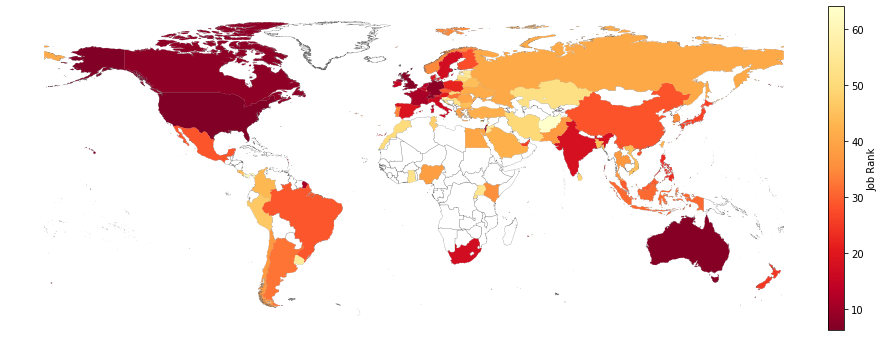

In [480]:
world_map(salary_jobs[['country', 'mean']], 'YlOrRd_r', 'Job Rank')

In [417]:
rank_life_dropped = rank_life.dropna()

In [524]:
rank_life_dropped['mean'] = rank_life_dropped.mean(axis=1)
rank_life_dropped.sort_values(by='mean').head(10)



C:\Users\Zaca\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,country,rank_crime,rank_health,rank_climate,rank_pollution,rank_groceries,rank_rent,rank_utilities,rank_public_transportation,mean
42,Georgia,3.0,84.0,31.0,76.0,4.0,35.0,26.0,9.0,33.500
117,Sri Lanka,50.0,20.0,69.0,48.0,52.0,18.0,13.0,1.0,33.875
13,Belarus,15.0,58.0,65.0,29.0,24.0,40.0,24.0,20.0,34.375
4,Argentina,108.0,30.0,1.0,35.0,18.0,20.0,41.0,25.0,34.750
127,Turkey,47.0,27.0,14.0,67.0,34.0,13.0,28.0,51.0,35.125
93,Pakistan,66.0,53.0,52.0,79.0,1.0,1.0,31.0,2.0,35.625
52,India,61.0,37.0,64.0,93.0,8.0,10.0,10.0,4.0,35.875
26,Colombia,96.0,36.0,6.0,55.0,12.0,30.0,35.0,53.0,40.375
35,Egypt,76.0,87.0,18.0,100.0,16.0,7.0,4.0,17.0,40.625
104,Romania,21.0,72.0,42.0,47.0,30.0,36.0,54.0,24.0,40.750


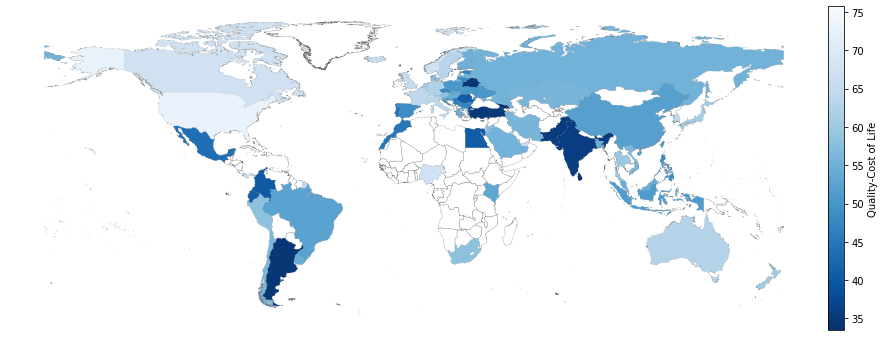

In [482]:
world_map(rank_life_dropped[['country', 'mean']], 'Blues_r', 'Quality-Cost of Life')

In [502]:
sorted_life = rank_life_dropped.sort_values(by='mean')[:25]
sorted_life['mean_quality'] = sorted_life[['rank_crime', 'rank_health', 'rank_pollution', 'rank_climate']].mean(axis=1)
sorted_life['mean_cost'] = sorted_life[['rank_rent', 'rank_utilities', 'rank_public_transportation', 'rank_groceries']].mean(axis=1)

In [508]:
sorted_life[sorted_life['country'] == 'Philippines'][['mean_cost', 'mean_quality']]

,mean_cost,mean_quality
99,36.5,60.25


In [443]:
salary_sorted = salary_jobs.sort_values(by='mean')[:25]
salary_sorted

,country,Data Scientist_x,Data Analyst_x,Business Analyst_x,Data Engineer_x,Data Engineer_y,Data Analyst_y,Business Analyst_y,Data Scientist_y,mean
5,United States Of America,6.0,2.0,20.0,15.0,1.0,2.0,3.0,1.0,6.250000
2,United Kingdom,3.0,4.0,8.0,3.0,7.0,11.0,8.0,12.0,7.000000
15,Australia,16.0,7.0,5.0,10.0,5.0,5.0,4.0,4.0,7.000000
9,Switzerland,10.0,17.0,2.0,9.0,2.0,14.0,1.0,2.0,7.125000
1,Germany,2.0,5.0,10.0,1.0,11.0,6.0,18.0,11.0,8.000000
8,Canada,9.0,6.0,9.0,7.0,8.0,12.0,10.0,5.0,8.250000
6,Israel,7.0,10.0,26.0,8.0,0.0,10.0,11.0,3.0,9.375000
7,Singapore,8.0,8.0,6.0,6.0,18.0,3.0,14.0,17.0,10.000000
0,France,1.0,1.0,3.0,2.0,19.0,22.0,19.0,22.0,11.125000
10,Hong Kong,11.0,11.0,1.0,17.0,25.0,16.0,0.0,14.0,11.875000


In [457]:
intersec = salary_sorted.merge(sorted_life, on='country')

In [458]:
intersec['value'] = 50

In [459]:
intersec

,country,Data Scientist_x,Data Analyst_x,Business Analyst_x,Data Engineer_x,Data Engineer_y,Data Analyst_y,Business Analyst_y,Data Scientist_y,mean_x,rank_crime,rank_health,rank_climate,rank_pollution,rank_groceries,rank_rent,rank_utilities,rank_public_transportation,mean_y,value
0,India,4.0,3.0,4.0,4.0,33.0,25.0,35.0,37.0,18.125,61.0,37.0,64.0,93.0,8.0,10.0,10.0,4.0,35.875,50
1,Spain,14.0,16.0,19.0,11.0,22.0,23.0,20.0,27.0,19.000,33.0,5.0,11.0,25.0,78.0,94.0,68.0,75.0,48.625,50
2,Poland,15.0,14.0,12.0,13.0,28.0,32.0,27.0,35.0,22.000,24.0,52.0,48.0,40.0,37.0,76.0,86.0,40.0,50.375,50
3,Philippines,20.0,9.0,11.0,23.0,NaN,4.0,47.0,47.0,23.000,59.0,35.0,67.0,80.0,47.0,26.0,67.0,6.0,48.375,50


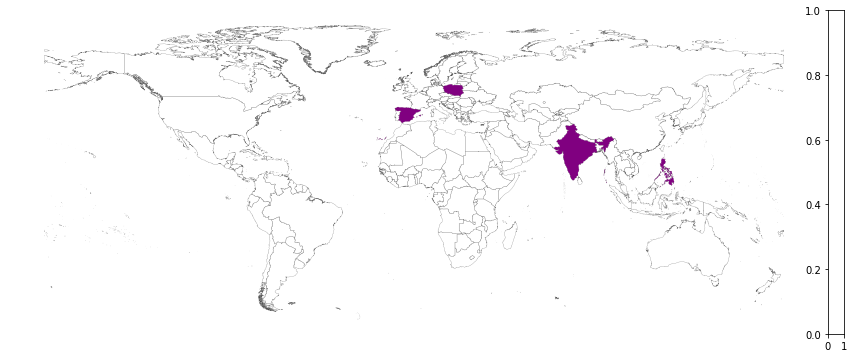

In [484]:
world_map(intersec['country'], 'Purples', 'Intersection')

In [520]:
#salary_jobs_da = rank_job.merge(rank_salary, on='country', how= 'outer')
#salary_jobs['mean'] = salary_jobs.mean(axis=1)

def get_top_25(job):
    da_salary_job= rank_job[['country', job]].merge(rank_salary[['country', job]], on='country', how='outer')
    da_salary_job.dropna(inplace=True)
    da_salary_job['mean'] = da_salary_job.mean(axis=1)
    da_salary_job = da_salary_job.sort_values(by='mean')[:20]
    inters = da_salary_job.merge(sorted_life, on='country')
    return inters
    

In [519]:
get_top_25('Business Analyst')

,country,Business Analyst_x,Business Analyst_y,mean_x,rank_crime,rank_health,rank_climate,rank_pollution,rank_groceries,rank_rent,rank_utilities,rank_public_transportation,mean_y,mean_quality,mean_cost
